In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from rv_study.rv_utils import *
from scipy.spatial import ConvexHull, convex_hull_plot_2d


Using TensorFlow backend.


regime classifier
Loading classifier
Train accuracy: 0.9887387387387387

Regression model generation_rate2
Loading Regressor
R square (R^2) for Train:                 0.987384

Regression model droplet_size2
Loading Regressor
R square (R^2) for Train:                 0.983142

Regression model generation_rate1
Loading Regressor
R square (R^2) for Train:                 0.965872

Regression model droplet_size1
Loading Regressor
R square (R^2) for Train:                 0.953238



In [2]:
orthogonal_devices = pd.read_csv("rv_study/orthogonal_devices.csv")

Dropped 0 points
Dropped 84 points
Dropped 48 points
Dropped 60 points
Dropped 69 points
Dropped 9 points
Dropped 3 points
Dropped 69 points
Dropped 153 points
Dropped 220 points
Dropped 0 points
Dropped 197 points
Dropped 82 points
Dropped 42 points
Dropped 212 points
Dropped 39 points
Dropped 202 points
Dropped 201 points
Dropped 77 points
Dropped 198 points
Dropped 1 points
Dropped 23 points
Dropped 133 points
Dropped 234 points
Dropped 123 points


Text(0.5, 1.0, 'Performance Span of Orthogonal Devices')

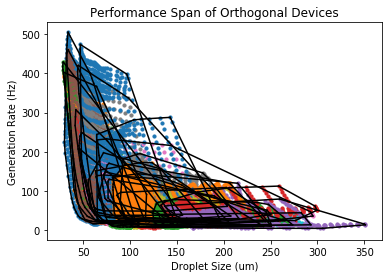

In [3]:
devices = orthogonal_devices.to_dict(orient='records')
score = []
size_score = []
rate_score = []
all_points = {}
hulls = []

for device in devices:
    features = device.copy()
    chip_num = features["Chip #"]
    del features["Chip #"]
    sizes, rates = sweep_results(device, sweep_size=25, jet_drop=True)
    size_score.append(np.max(sizes) - np.min(sizes))
    rate_score.append(np.max(rates) - np.min(rates))
    points = np.array([[sizes[i], rates[i]] for i in range(len(sizes))])
    all_points[chip_num] = points
    hull = ConvexHull(points)
    hulls.append(hull)
    plt.scatter(points[:,0], points[:,1], s=10)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    score.append(hull.volume)
orthogonal_devices["hull_object"] = hulls
plt.xlabel("Droplet Size (um)")
plt.ylabel("Generation Rate (Hz)")
plt.title("Performance Span of Orthogonal Devices")

(0, 500)

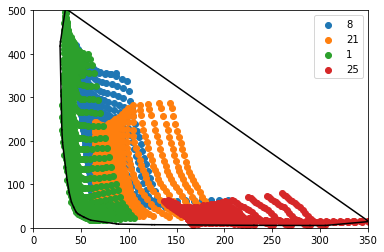

In [7]:
entire_space = []
for key in all_points.keys():
    entire_space.extend(all_points[key])
entire_space= np.array(entire_space)
design_space_hull = ConvexHull(entire_space)

plt.scatter(all_points[8][:,0], all_points[8][:,1])
#plt.scatter(all_points[11][:,0], all_points[11][:,1])
#plt.scatter(all_points[3][:,0], all_points[3][:,1])
plt.scatter(all_points[21][:,0], all_points[21][:,1])
plt.scatter(all_points[1][:,0], all_points[1][:,1])
plt.scatter(all_points[25][:,0], all_points[25][:,1])
plt.legend(["8", "21", "1", "25"])
for simplex in design_space_hull.simplices:
    plt.plot(entire_space[simplex, 0], entire_space[simplex, 1], 'k-')

plt.xlim([0, 350])
plt.ylim([0, 500])

In [ ]:
# Making minimal setup
target = 0.99
coverage = 0.0
hulls = orthogonal_devices["hull_object"].to_dict()
devices_left = len(hulls)
points_left = []
points_used = []
used = []
areas = list(np.zeros(len(hulls)))

for key in all_points.keys():
    points_left.extend(all_points[key])
area_left = ConvexHull(points_left).volume
design_space_area = area_left

count = 1
while coverage <= target or count < 25:
    ## 1.1 Calculate area of each device hull
    for key in hulls:
        if key not in used:
            areas[key] = hulls[key].volume
    ## 1.2 pick hull with maximum area
    max_chip = areas.index(max(areas)) #requires 2 iterations but list is small
    print(max_chip)
    print(used)
    print(areas)
    used.append(max_chip)
    ## 1.3 remove all points WITHIN hull (& add to min dataset). This is for the full devices and for any overlaps
    points_left = []
    for chip_num in all_points.keys():
        points_placeholder = []
        for i, point in enumerate(all_points[chip_num]):
            if not in_hull(point, hulls[max_chip].points):
                points_placeholder.append(point)
            else:
                points_used.append(point)
        all_points[int(chip_num)] = np.array(points_placeholder) # Delete point if it is inside of the current point
        points_left.extend(all_points[chip_num])
        if chip_num-1 in used or len(all_points[chip_num]) < 3:
            areas[int(chip_num)-1] = -1
            if chip_num - 1 not in used:
                used.append(chip_num-1)
        else:
            hulls[int(chip_num)-1] = ConvexHull(all_points[chip_num])
        
    area_left = ConvexHull(points_used).a
    coverage = area_left/design_space_area
    print("Iteration %f, Coverage %f" % (count, coverage))
    count+=1
    if count > 25:
        break
    if coverage >= 0.99:
        break
    
    
# 1. Calculate device area intersect with design space hull -> harder than thought? Can I just do this with a discrete method...? (by parts)
## 1.4 Show amount coverage with existing device
## 1.5 Iterate



# 2. Pick Max intersect value
# 3. Subtract from current hull
# 4. Iterate over it

7
[]
[19732.85007851508, 20473.208527590818, 22652.084883804007, 13971.957991146213, 12416.199607601275, 17262.163983915994, 8082.169138446894, 30505.185247400368, 12702.480217596174, 12806.110778198074, 27697.1671594247, 13503.34103805157, 15519.870970991615, 12383.728211449381, 15485.009684443146, 14146.910792321032, 28640.471731179387, 14930.913803924375, 12318.259364225525, 4757.2461070688605, 26525.54811639873, 17179.236449824642, 8453.704103663153, 11155.331774823031, 10846.110748488947]


In [20]:
orthogonal_devices["score"] = score
orthogonal_devices["size_score"] = size_score
orthogonal_devices["rate_score"] = rate_score


In [23]:
orthogonal_devices

,Chip #,orifice_size,aspect_ratio,expansion_ratio,normalized_water_inlet,normalized_oil_inlet,normalized_orifice_length,hull_object,score,size_score,rate_score
0,1,75,1.0,2,2.0,2.0,1.0,<scipy.spatial.qhull.ConvexHull object at 0x00...,19732.850079,75.850723,487.223572
1,2,75,1.5,3,2.5,2.5,1.5,<scipy.spatial.qhull.ConvexHull object at 0x00...,20473.208528,88.350449,381.653870
2,3,75,2.0,4,3.0,3.0,2.0,<scipy.spatial.qhull.ConvexHull object at 0x00...,22652.084884,127.618462,408.404083
3,4,75,2.5,5,3.5,3.5,2.5,<scipy.spatial.qhull.ConvexHull object at 0x00...,13971.957991,104.809311,292.171844
4,5,75,3.0,6,4.0,4.0,3.0,<scipy.spatial.qhull.ConvexHull object at 0x00...,12416.199608,106.265106,236.097397
5,6,100,1.0,3,3.5,4.0,2.0,<scipy.spatial.qhull.ConvexHull object at 0x00...,17262.163984,82.654297,438.374481
6,7,100,1.5,4,4.0,2.0,2.5,<scipy.spatial.qhull.ConvexHull object at 0x00...,8082.169138,100.097321,197.082642
7,8,100,2.0,5,2.0,2.5,3.0,<scipy.spatial.qhull.ConvexHull object at 0x00...,30505.185247,159.692535,371.137573
8,9,100,2.5,6,2.5,3.0,1.0,<scipy.spatial.qhull.ConvexHull object at 0x00...,12702.480218,178.354843,140.471588
9,10,100,3.0,2,3.0,3.5,1.5,<scipy.spatial.qhull.ConvexHull object at 0x00...,12806.110778,143.330017,158.885239


Text(0, 0.5, 'Range (max - min)')

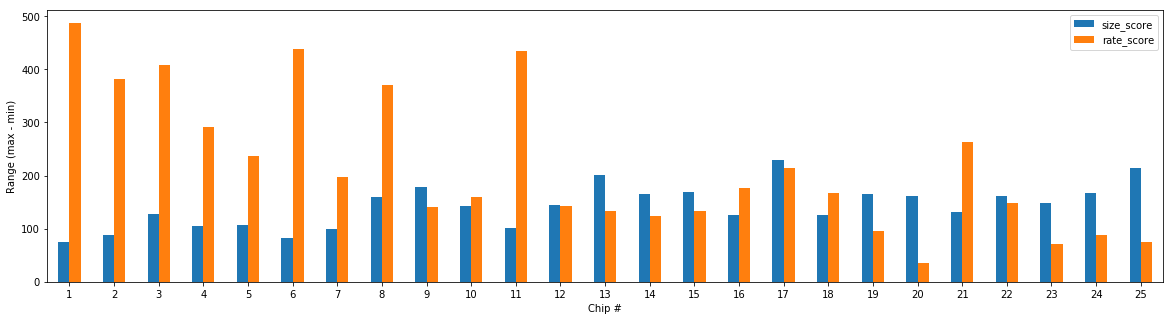

In [21]:
ax = orthogonal_devices.plot.bar(x="Chip #", y=["size_score","rate_score"], rot=0, figsize=[20,5])
ax.set_ylabel("Range (max - min)")

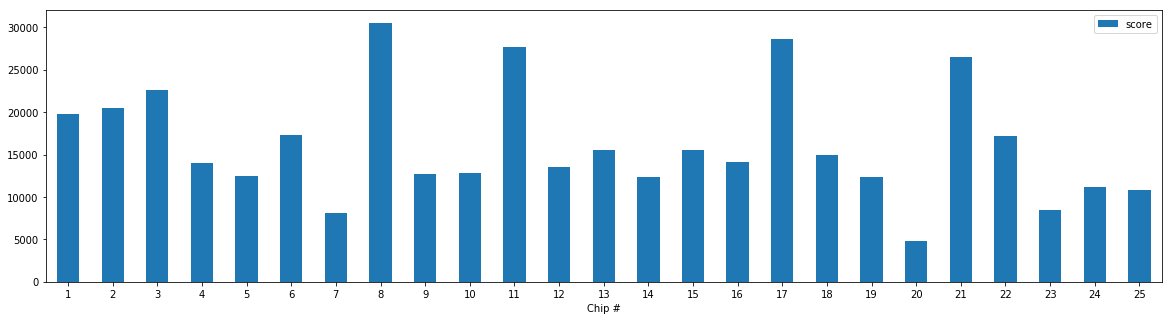

In [22]:
ax = orthogonal_devices.plot.bar(x="Chip #", y=["score"], rot=0, figsize=[20,5])
ax.set_ylabel("Convex Hull area")